# Solar Power Generation Prediction Training

* I preprocessed data first, trained the model
* Used 1D-CNN model for time series
* The model predicts the amount of power generation of 73th hour by using data of previous 72 hours
* Has four generators in two regions => trained four models using same structure

In [ ]:
#Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from google.colab import drive
from datetime import datetime, timedelta

import math
import time
import random

import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.externals import joblib

drive.mount('./gdrive', force_remount=True)
plt.style.use("fivethirtyeight")
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Mounted at ./gdrive


In [ ]:
dangjin_fcst = pd.read_csv("new_dangjin_fcst.csv")
ulsan_fcst = pd.read_csv("new_ulsan_fcst.csv")
energy = pd.read_csv("new_energy.csv")

In [ ]:
# concat Insolation and Amount of Sunshine

chch_sun=pd.read_csv("prep_chch_sun.csv")
ulsan_sun=pd.read_csv("prep_ulsan_sun.csv")
chch_sun.rename(columns={'일시':'Forecast_time','일조(hr)':'일조','일사(MJ/m2)':'일사'}, inplace=True)
ulsan_sun.rename(columns={'일시':'Forecast_time','일조(hr)':'일조','일사(MJ/m2)':'일사'}, inplace=True)

In [ ]:
dangjin_fcst

,Forecast_time,Temperature,PrecipitationForm,PrecipitationProb,Humidity,WindSpeed,WindDirection,Cloud,Precipitation,Snow,방위각,고도,적경,적위
0,2016-12-02 00:00:00,0.4,0.0,0.0,67.0,8.6,356.0,1.0,NaN,NaN,340 03 04.02,-74 04 10.40,16 32 56.04,-21 55 49.38
1,2016-12-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,030 19 39.37,-72 55 00.56,16 33 06.98,-21 56 11.79
2,2016-12-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,060 54 26.99,-64 12 35.47,16 33 17.92,-21 56 34.29
3,2016-12-02 03:00:00,-0.7,0.0,0.0,76.0,2.7,341.0,1.0,NaN,NaN,077 02 49.13,-53 01 39.40,16 33 28.84,-21 56 56.88
4,2016-12-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,087 49 23.81,-41 10 38.68,16 33 39.74,-21 57 19.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37196,2021-02-28 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274 36 31.31,-19 28 58.57,22 43 34.22,-8 04 37.23
37197,2021-02-28 21:00:00,7.0,0.0,30.0,70.0,1.3,18.0,4.0,NaN,NaN,284 38 48.32,-31 16 00.31,22 43 43.68,-8 03 40.40
37198,2021-02-28 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296 55 39.10,-42 26 50.80,22 43 53.17,-8 02 43.58
37199,2021-02-28 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313 32 08.08,-52 14 15.85,22 44 02.67,-8 01 46.80


# Preprocessing

In [ ]:
energy['time'] = pd.to_datetime(dangjin_fcst['Forecast_time'][:len(energy)])
energy['year'] = energy['time'].dt.year
energy['month'] = energy['time'].dt.month
energy['day'] = energy['time'].dt.day
energy['hour'] = energy['time'].dt.hour
energy['year-month-day'] = energy['year'].astype(str) + "-" + energy['month'].astype(str) + "-" + energy['day'].astype(str)

In [ ]:
date = dangjin_fcst['Forecast_time']

In [ ]:
dangjin_fcst['Temperature'] = dangjin_fcst['Temperature'].interpolate() 
dangjin_fcst['PrecipitationForm'] = dangjin_fcst['PrecipitationForm'].interpolate()
dangjin_fcst['PrecipitationProb'] = dangjin_fcst['PrecipitationProb'].interpolate()
dangjin_fcst['Humidity'] = dangjin_fcst['Humidity'].interpolate()
dangjin_fcst['WindSpeed'] = dangjin_fcst['WindSpeed'].interpolate()
dangjin_fcst['Cloud'] = dangjin_fcst['Cloud'].interpolate()
dangjin_fcst['Precipitation'] = dangjin_fcst['Precipitation'].interpolate()
dangjin_fcst['Snow'] = dangjin_fcst['Snow'].interpolate()


ulsan_fcst['Temperature'] = ulsan_fcst['Temperature'].interpolate()
ulsan_fcst['PrecipitationForm'] = ulsan_fcst['PrecipitationForm'].interpolate()
ulsan_fcst['PrecipitationProb'] = ulsan_fcst['PrecipitationProb'].interpolate()
ulsan_fcst['Humidity'] = ulsan_fcst['Humidity'].interpolate()
ulsan_fcst['WindSpeed'] = ulsan_fcst['WindSpeed'].interpolate()
ulsan_fcst['Cloud'] = ulsan_fcst['Cloud'].interpolate()
ulsan_fcst['Precipitation'] = ulsan_fcst['Precipitation'].interpolate()
ulsan_fcst['Snow'] = ulsan_fcst['Snow'].interpolate()

In [ ]:
dangjin_fcst['Wind_x'] = dangjin_fcst['Wind_x'].interpolate()
dangjin_fcst['Wind_y'] = dangjin_fcst['Wind_y'].interpolate()

ulsan_fcst['Wind_x'] = ulsan_fcst['Wind_x'].interpolate()
ulsan_fcst['Wind_y'] = ulsan_fcst['Wind_y'].interpolate()

In [ ]:
dangjin_fcst=pd.merge(dangjin_fcst, chch_sun, how='left', on='Forecast_time')
ulsan_fcst=pd.merge(ulsan_fcst, ulsan_sun, how='left', on='Forecast_time')

In [ ]:
dangjin_fcst

,Forecast_time,Temperature,PrecipitationForm,PrecipitationProb,Humidity,WindSpeed,WindDirection,Cloud,Precipitation,Snow,방위각,고도,적경,적위,WindDirection_x,WindDirection_y,Wind_x,Wind_y,WindDirection_catg,일조,일사
0,2016-12-02 00:00:00,0.400000,0.0,0.0,67.000000,8.600000,356.000000,1.0,NaN,NaN,340 03 04.02,-74 04 10.40,16 32 56.04,-21 55 49.38,-0.069756,0.997564,-0.599906,8.579051,N,0.0,0.0
1,2016-12-02 01:00:00,0.033333,0.0,0.0,70.000000,6.633333,351.000000,1.0,NaN,NaN,030 19 39.37,-72 55 00.56,16 33 06.98,-21 56 11.79,NaN,NaN,-0.692948,6.570334,N,0.0,0.0
2,2016-12-02 02:00:00,-0.333333,0.0,0.0,73.000000,4.666667,346.000000,1.0,NaN,NaN,060 54 26.99,-64 12 35.47,16 33 17.92,-21 56 34.29,NaN,NaN,-0.785991,4.561617,N,0.0,0.0
3,2016-12-02 03:00:00,-0.700000,0.0,0.0,76.000000,2.700000,341.000000,1.0,NaN,NaN,077 02 49.13,-53 01 39.40,16 33 28.84,-21 56 56.88,-0.325568,0.945519,-0.879034,2.552900,N,0.0,0.0
4,2016-12-02 04:00:00,-0.933333,0.0,0.0,80.000000,2.366667,341.333333,1.0,NaN,NaN,087 49 23.81,-41 10 38.68,16 33 39.74,-21 57 19.52,NaN,NaN,-0.761132,2.240865,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37196,2021-02-28 20:00:00,7.666667,0.0,30.0,66.666667,1.133333,124.333333,4.0,0.0,0.0,274 36 31.31,-19 28 58.57,22 43 34.22,-8 04 37.23,NaN,NaN,0.163620,1.069717,SE,0.0,0.0
37197,2021-02-28 21:00:00,7.000000,0.0,30.0,70.000000,1.300000,18.000000,4.0,0.0,0.0,284 38 48.32,-31 16 00.31,22 43 43.68,-8 03 40.40,0.309017,0.951057,0.401722,1.236373,N,0.0,0.0
37198,2021-02-28 22:00:00,6.666667,0.0,30.0,68.333333,1.300000,27.000000,4.0,0.0,0.0,296 55 39.10,-42 26 50.80,22 43 53.17,-8 02 43.58,NaN,NaN,0.574228,1.130662,NE,0.0,0.0
37199,2021-02-28 23:00:00,6.333333,0.0,30.0,66.666667,1.300000,36.000000,4.0,0.0,0.0,313 32 08.08,-52 14 15.85,22 44 02.67,-8 01 46.80,NaN,NaN,0.746733,1.024950,NE,0.0,0.0


In [ ]:
dangjin_fcst['hour'] = pd.to_datetime(dangjin_fcst['Forecast_time']).dt.hour
dangjin_fcst['day'] = pd.to_datetime(dangjin_fcst['Forecast_time']).dt.day
dangjin_fcst['month'] = pd.to_datetime(dangjin_fcst['Forecast_time']).dt.month

ulsan_fcst['hour'] = pd.to_datetime(ulsan_fcst['Forecast_time']).dt.hour
ulsan_fcst['day'] = pd.to_datetime(ulsan_fcst['Forecast_time']).dt.day
ulsan_fcst['month'] = pd.to_datetime(ulsan_fcst['Forecast_time']).dt.month

In [ ]:
#Add dewpoint by calculation
b = 17.62
c = 243.12
gamma = (b * dangjin_fcst['Temperature'] /(c + dangjin_fcst['Temperature'])) + np.log(dangjin_fcst['Humidity'] / 100.0)
dewpoint = (c * gamma) / (b - gamma)
dangjin_fcst['DewPoint'] = dewpoint  

gamma = (b * ulsan_fcst['Temperature'] /(c + ulsan_fcst['Temperature'])) + np.log(ulsan_fcst['Humidity'] / 100.0)
dewpoint = (c * gamma) / (b - gamma)
ulsan_fcst['DewPoint'] = dewpoint

In [ ]:
dangjin_fcst['방위각'] = dangjin_fcst['방위각'].apply(lambda x : int(x[:3]))
dangjin_fcst['고도'] = dangjin_fcst['고도'].apply(lambda x : int(x.split(" ")[0]))
dangjin_fcst['적경'] = dangjin_fcst['적경'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))
dangjin_fcst['적위'] = dangjin_fcst['적위'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))

ulsan_fcst['방위각'] = ulsan_fcst['방위각'].apply(lambda x : int(x[:3]))
ulsan_fcst['고도'] = ulsan_fcst['고도'].apply(lambda x : int(x.split(" ")[0]))
ulsan_fcst['적경'] = ulsan_fcst['적경'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))
ulsan_fcst['적위'] = ulsan_fcst['적위'].apply(lambda x : float(x.split(" ")[0] + "." + x.split(" ")[1] + x.split(" ")[2][:2]))

In [ ]:
using_col = ['Temperature', 'DewPoint', 'Humidity', 'Cloud', 'Wind_x', 'Wind_y', 'hour', 'month', '방위각', '고도', '적경', '적위','일사','일조']
dangjin_fcst = dangjin_fcst[using_col].fillna(0)
ulsan_fcst = ulsan_fcst[using_col].fillna(0)

In [ ]:
dangjin_fcst

,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조
0,0.400000,-5.020566,67.000000,1.0,-0.599906,8.579051,0,12,340,-74,16.3256,-21.5549,0.0,0.0
1,0.033333,-4.791717,70.000000,1.0,-0.692948,6.570334,1,12,30,-72,16.3306,-21.5611,0.0,0.0
2,-0.333333,-4.587913,73.000000,1.0,-0.785991,4.561617,2,12,60,-64,16.3317,-21.5634,0.0,0.0
3,-0.700000,-4.407317,76.000000,1.0,-0.879034,2.552900,3,12,77,-53,16.3328,-21.5656,0.0,0.0
4,-0.933333,-3.950599,80.000000,1.0,-0.761132,2.240865,4,12,87,-41,16.3339,-21.5719,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37196,7.666667,1.851700,66.666667,4.0,0.163620,1.069717,20,2,274,-19,22.4334,-8.0437,0.0,0.0
37197,7.000000,1.897402,70.000000,4.0,0.401722,1.236373,21,2,284,-31,22.4343,-8.0340,0.0,0.0
37198,6.666667,1.241159,68.333333,4.0,0.574228,1.130662,22,2,296,-42,22.4353,-8.0243,0.0,0.0
37199,6.333333,0.579324,66.666667,4.0,0.746733,1.024950,23,2,313,-52,22.4402,-8.0146,0.0,0.0


In [ ]:
# Shift => like window sliding
# slide for 72 hours, each row contains latest 72 hours of data
def shift(df, period):
  target = pd.DataFrame()
  for i in range(period, -1, -1): 
    tmp = df.shift(i) 
    target = pd.concat([target, tmp], axis = 1)
  return target

In [ ]:
dangjin_fcst = shift(dangjin_fcst, 71)  
ulsan_fcst = shift(ulsan_fcst, 71)                                            

In [ ]:
dangjin_fcst

,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,...,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,-5.020566,67.000000,1.0,-0.599906,8.579051,0,12,340,-74,16.3256,-21.5549,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,-5.020566,67.000000,1.0,-0.599906,8.579051,0.0,12.0,340.0,-74.0,16.3256,-21.5549,0.0,0.0,0.033333,-4.791717,70.000000,1.0,-0.692948,6.570334,1,12,30,-72,16.3306,-21.5611,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.000000,1.0,-0.599906,8.579051,0.0,12.0,340.0,-74.0,16.3256,-21.5549,0.00,0.0,0.033333,-4.791717,70.000000,1.0,-0.692948,6.570334,1.0,12.0,30.0,-72.0,16.3306,-21.5611,0.0,0.0,-0.333333,-4.587913,73.000000,1.0,-0.785991,4.561617,2,12,60,-64,16.3317,-21.5634,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70.000000,1.0,-0.692948,6.570334,1.0,12.0,30.0,-72.0,16.3306,-21.5611,0.00,0.0,-0.333333,-4.587913,73.000000,1.0,-0.785991,4.561617,2.0,12.0,60.0,-64.0,16.3317,-21.5634,0.0,0.0,-0.700000,-4.407317,76.000000,1.0,-0.879034,2.552900,3,12,77,-53,16.3328,-21.5656,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.000000,1.0,-0.785991,4.561617,2.0,12.0,60.0,-64.0,16.3317,-21.5634,0.00,0.0,-0.700000,-4.407317,76.000000,1.0,-0.879034,2.552900,3.0,12.0,77.0,-53.0,16.3328,-21.5656,0.0,0.0,-0.933333,-3.950599,80.000000,1.0,-0.761132,2.240865,4,12,87,-41,16.3339,-21.5719,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37196,3.000000,-0.115438,80.000000,4.0,0.414110,1.545481,21.0,2.0,283.0,-31.0,22.3224,-9.1106,0.0,0.0,2.333333,-1.347498,76.666667,3.0,0.684631,1.373141,22.0,2.0,295.0,-43.0,22.3233,-9.1010,0.0,0.0,1.666667,-2.596163,73.333333,2.0,0.955151,1.200801,23.0,2.0,312.0,-53.0,22.3243,-9.0914,...,60.000000,4.0,-0.312585,0.736404,18.0,2.0,256.0,4.0,22.4315,-8.0630,0.22,0.0,8.333333,1.767587,63.333333,4.0,-0.074483,0.903060,19.0,2.0,265.0,-7.0,22.4324,-8.0534,0.0,0.0,7.666667,1.851700,66.666667,4.0,0.163620,1.069717,20,2,274,-19,22.4334,-8.0437,0.0,0.0
37197,2.333333,-1.347498,76.666667,3.0,0.684631,1.373141,22.0,2.0,295.0,-43.0,22.3233,-9.1010,0.0,0.0,1.666667,-2.596163,73.333333,2.0,0.955151,1.200801,23.0,2.0,312.0,-53.0,22.3243,-9.0914,0.0,0.0,1.000000,-3.863107,70.000000,1.0,1.225671,1.028460,0.0,2.0,336.0,-60.0,22.3252,-9.0818,...,63.333333,4.0,-0.074483,0.903060,19.0,2.0,265.0,-7.0,22.4324,-8.0534,0.00,0.0,7.666667,1.851700,66.666667,4.0,0.163620,1.069717,20.0,2.0,274.0,-19.0,22.4334,-8.0437,0.0,0.0,7.000000,1.897402,70.000000,4.0,0.401722,1.236373,21,2,284,-31,22.4343,-8.0340,0.0,0.0
37198,1.666667,-2.596163,73.333333,2.0,0.955151,1.200801

* train test split for training

In [ ]:
dangjin_fcst_2 = pd.read_csv("new_dangjin_fcst.csv")

In [ ]:
dangjin_fcst_2.iloc[-24 * 28:] 

,Forecast_time,Temperature,PrecipitationForm,PrecipitationProb,Humidity,WindSpeed,WindDirection,Cloud,Precipitation,Snow,방위각,고도,적경,적위
36529,2021-02-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,008 56 11.92,-70 09 22.58,20 54 45.62,-17 24 17.68
36530,2021-02-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,044 01 52.60,-64 39 23.47,20 54 55.98,-17 23 35.90
36531,2021-02-01 03:00:00,7.0,1.0,60.0,90.0,3.4,207.0,4.0,NaN,NaN,065 02 44.48,-54 50 37.38,20 55 06.32,-17 22 54.18
36532,2021-02-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,078 27 00.60,-43 28 07.22,20 55 16.65,-17 22 12.52
36533,2021-02-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,088 33 04.07,-31 34 49.77,20 55 26.95,-17 21 30.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37196,2021-02-28 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274 36 31.31,-19 28 58.57,22 43 34.22,-8 04 37.23
37197,2021-02-28 21:00:00,7.0,0.0,30.0,70.0,1.3,18.0,4.0,NaN,NaN,284 38 48.32,-31 16 00.31,22 43 43.68,-8 03 40.40
37198,2021-02-28 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296 55 39.10,-42 26 50.80,22 43 53.17,-8 02 43.58
37199,2021-02-28 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313 32 08.08,-52 14 15.85,22 44 02.67,-8 01 46.80


In [ ]:
dangjin_fcst_train = dangjin_fcst.iloc[:-24 * 28]
dangjin_fcst_test = dangjin_fcst.iloc[-24 * 28:]

ulsan_fcst_train = ulsan_fcst.iloc[:-24 * 28]
ulsan_fcst_test = ulsan_fcst.iloc[-24 * 28:]

In [ ]:
#Delete the first 72 data as those can't contain all of latest 72 hours of data
energy = energy[(dangjin_fcst_train.isnull().sum(axis = 1) <= 0).values]
ulsan_fcst_train = ulsan_fcst_train[(dangjin_fcst_train.isnull().sum(axis = 1) <= 0).values]
dangjin_fcst_train = dangjin_fcst_train[(dangjin_fcst_train.isnull().sum(axis = 1) <= 0).values]

In [ ]:
#min max scaling
dangjin_min = dangjin_fcst_train.min()
dangjin_max = dangjin_fcst_train.max()

dangjin_fcst_train = (dangjin_fcst_train - dangjin_min) / (dangjin_max - dangjin_min)
dangjin_fcst_test = (dangjin_fcst_test - dangjin_min) / (dangjin_max - dangjin_min)

In [ ]:
ulsan_min = ulsan_fcst_train.min()
ulsan_max = ulsan_fcst_train.max()

ulsan_fcst_train = (ulsan_fcst_train - ulsan_min) / (ulsan_max - ulsan_min)
ulsan_fcst_test = (ulsan_fcst_test - ulsan_min) / (ulsan_max - ulsan_min)

# Model

In [ ]:
import tensorflow as tf

In [ ]:
dangjin_fcst_train

,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,...,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조,Temperature,DewPoint,Humidity,Cloud,Wind_x,Wind_y,hour,month,방위각,고도,적경,적위,일사,일조
71,0.293878,0.321815,0.633333,0.000000,0.372243,0.749774,0.000000,1.0,0.968571,0.006667,0.691902,0.036692,0.0,0.0,0.286395,0.326229,0.666667,0.000000,0.370026,0.707605,0.043478,1.0,0.082857,0.020000,0.692114,0.036558,0.0,0.0,0.278912,0.330161,0.700000,0.000000,0.367809,0.665436,0.086957,1.0,0.168571,0.073333,0.692161,0.036509,...,0.866667,1.0,0.401532,0.553359,0.913043,1.0,0.777143,0.213333,0.697272,0.022931,0.000000,0.0,0.417687,0.508851,0.870370,1.0,0.397723,0.556202,0.956522,1.0,0.811429,0.133333,0.697319,0.022804,0.0,0.0,0.421088,0.513063,0.874074,1.0,0.393915,0.559045,1.000000,1.000000,0.862857,0.060000,0.697365,0.022763,0.0,0.0
72,0.286395,0.326229,0.666667,0.000000,0.370026,0.707605,0.043478,1.0,0.082857,0.020000,0.692114,0.036558,0.0,0.0,0.278912,0.330161,0.700000,0.000000,0.367809,0.665436,0.086957,1.0,0.168571,0.073333,0.692161,0.036509,0.0,0.0,0.271429,0.333644,0.733333,0.000000,0.365593,0.623267,0.130435,1.0,0.217143,0.146667,0.692207,0.036462,...,0.870370,1.0,0.397723,0.556202,0.956522,1.0,0.811429,0.133333,0.697319,0.022804,0.000000,0.0,0.421088,0.513063,0.874074,1.0,0.393915,0.559045,1.000000,1.0,0.862857,0.060000,0.697365,0.022763,0.0,0.0,0.424490,0.517275,0.877778,1.0,0.390107,0.561888,0.000000,1.000000,0.962857,0.006667,0.697412,0.022722,0.0,0.0
73,0.278912,0.330161,0.700000,0.000000,0.367809,0.665436,0.086957,1.0,0.168571,0.073333,0.692161,0.036509,0.0,0.0,0.271429,0.333644,0.733333,0.000000,0.365593,0.623267,0.130435,1.0,0.217143,0.146667,0.692207,0.036462,0.0,0.0,0.266667,0.342454,0.777778,0.000000,0.368402,0.616716,0.173913,1.0,0.245714,0.226667,0.692254,0.036326,...,0.874074,1.0,0.393915,0.559045,1.000000,1.0,0.862857,0.060000,0.697365,0.022763,0.000000,0.0,0.424490,0.517275,0.877778,1.0,0.390107,0.561888,0.000000,1.0,0.962857,0.006667,0.697412,0.022722,0.0,0.0,0.416327,0.512755,0.888889,1.0,0.387533,0.550541,0.043478,1.000000,0.082857,0.013333,0.697628,0.022595,0.0,0.0
74,0.271429,0.333644,0.733333,0.000000,0.365593,0.623267,0.130435,1.0,0.217143,0.146667,0.692207,0.036462,0.0,0.0,0.266667,0.342454,0.777778,0.000000,0.368402,0.616716,0.173913,1.0,0.245714,0.226667,0.692254,0.036326,0.0,0.0,0.261905,0.350642,0.822222,0.000000,0.371211,0.610166,0.217391,1.0,0.271429,0.306667,0.692301,0.036277,...,0.877778,1.0,0.390107,0.561888,0.000000,1.0,0.962857,0.006667,0.697412,0.022722,0.000000,0.0,0.416327,0.512755,0.888889,1.0,0.387533,0.550541,0.043478,1.0,0.082857,0.013333,0.697628,0.022595,0.0,0.0,0.408163,0.508185,0.900000,1.0,0.384958,0.539195,0.086957,1.000000,0.171429,0.073333,0.697675,0.022552,0.0,0.0
75,0.266667,0.342454,0.777778,0.000000,0.368402,0.616716,0.173913,1.0,0.245714,0.226667,0.692254,0.036326,0.0,0.0,0.261905,0.350642,0.822222,0.000000,0.371211,0.610166,0.217391,1.0,0.271429,0.306667,0.692301,0.036277,0.0,0.0,0.257143,0.358262,0.866667,0.000000,0.374020,0.603615,0.260870,1.0,0.294286,0.386667,0.692517,0.036144,...,0.888889,1.0,0.387533,0.550541,0.043478,1.0,0.082857,0.013333,0.697628,0.022595,0.000000,0.0,0.408163,0.508185,0.900000,1.0,0.384958,0.539195,0.086957,1.0,0.171429,0.073333,0.697675,0.022552,0.0,0.0,0.400000,0.503567,0.911111,1.0,0.382384,0.527848,0.130435,1.000000,0.217143,0.146667,0.697721,0.022512,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3652

In [ ]:
dangjin_fcst_train = dangjin_fcst_train.values.reshape((dangjin_fcst_train.shape[0], 72, 14, 1)) #(36458, 864) -> (36458, 72, 12, 1)
dangjin_fcst_test = dangjin_fcst_test.values.reshape((dangjin_fcst_test.shape[0], 72, 14, 1))

ulsan_fcst_train = ulsan_fcst_train.values.reshape((ulsan_fcst_train.shape[0], 72, 14, 1))
ulsan_fcst_test = ulsan_fcst_test.values.reshape((ulsan_fcst_test.shape[0], 72, 14, 1))

In [ ]:
dangjin_fcst_train = np.squeeze(dangjin_fcst_train, axis = -1)
dangjin_fcst_train = np.stack((dangjin_fcst_train,)*3, axis = -1)

dangjin_fcst_test = np.squeeze(dangjin_fcst_test, axis = -1)
dangjin_fcst_test = np.stack((dangjin_fcst_test,)*3, axis = -1)

ulsan_fcst_train = np.squeeze(ulsan_fcst_train, axis = -1)
ulsan_fcst_train = np.stack((ulsan_fcst_train,)*3, axis = -1)

ulsan_fcst_test = np.squeeze(ulsan_fcst_test, axis = -1)
ulsan_fcst_test = np.stack((ulsan_fcst_test,)*3, axis = -1)

In [ ]:
def my_model(n_filters=10, fsize=5):
  new_model = tf.keras.Sequential()
  new_model.add(tf.keras.layers.Conv2D(n_filters, (1, fsize), padding='same', activation='relu', input_shape=dangjin_fcst_train.shape[1:]))
  new_model.add(tf.keras.layers.Flatten())
  new_model.add(tf.keras.layers.Dense(1000, activation='relu'))
  new_model.add(tf.keras.layers.Dropout(0.3))
  new_model.add(tf.keras.layers.Dense(500, activation='relu'))
  new_model.add(tf.keras.layers.Dropout(0.3))
  new_model.add(tf.keras.layers.Dense(100, activation='relu'))
  new_model.add(tf.keras.layers.Dense(1))
   
  return new_model

In [ ]:
def make_dataset(df, col):
  X = df[energy[col].notnull() & energy[col]!=0]
  y = energy[energy[col].notnull() & energy[col]!=0]

  tmp = y.groupby(['year', 'month', 'day']).mean()
  tmp = tmp.query("%s == 0"%col).reset_index()
  tmp['year-month-day'] = tmp['year'].astype(str) + "-" + tmp['month'].astype(str) + "-" + tmp['day'].astype(str)

  X = X[~y['year-month-day'].isin(tmp['year-month-day'])]
  y = y[~y['year-month-day'].isin(tmp['year-month-day'])][col]
  return X, y.values

In [ ]:
floating_X, floating_y = make_dataset(dangjin_fcst_train, "dangjin_floating")

In [ ]:
#5-Fold for each model
#1 model each for 4 different generators => train 4 models using same structure
from keras import optimizers
BATCH_SIZE = 128
EPOCH = 30
fold = 5

kfold = KFold(n_splits = fold, shuffle = True, random_state = 42)
for i, (train_idx, val_idx) in enumerate(kfold.split(floating_X, floating_y)):

  X_train, X_val = floating_X[train_idx], floating_X[val_idx]
  y_train, y_val = floating_y[train_idx], floating_y[val_idx]
  
  model_path = './model/floating_fold%s.h5'%i
  model = my_model()
  #optim = tf.keras.optimizers.Adam(lr=0.0001)
  model.compile(optimizer = 'Adam', loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 5)])

Epoch 1/30
83/83 [==============================] - 30s 21ms/step - loss: 24795.8750 - mae: 117.8268 - val_loss: 7751.9810 - val_mae: 62.0803
Epoch 2/30
83/83 [==============================] - 1s 16ms/step - loss: 7582.4429 - mae: 61.9538 - val_loss: 5704.9707 - val_mae: 51.1292
Epoch 3/30
83/83 [==============================] - 1s 16ms/step - loss: 6199.3936 - mae: 54.8926 - val_loss: 5239.8662 - val_mae: 49.0001
Epoch 4/30
83/83 [==============================] - 1s 16ms/step - loss: 5894.4292 - mae: 53.4361 - val_loss: 5445.9043 - val_mae: 50.0106
Epoch 5/30
83/83 [==============================] - 1s 16ms/step - loss: 5584.6758 - mae: 51.7539 - val_loss: 5744.6533 - val_mae: 51.6470
Epoch 6/30
83/83 [==============================] - 1s 16ms/step - loss: 5477.9570 - mae: 51.1281 - val_loss: 5741.3828 - val_mae: 51.4233
Epoch 7/30
83/83 [==============================] - 1s 16ms/step - loss: 5344.7700 - mae: 50.4771 - val_loss: 6601.1460 - val_mae: 57.6024
Epoch 8/30
83/83 [======

In [ ]:
warehouse_X, warehouse_y = make_dataset(dangjin_fcst_train, "dangjin_warehouse")

In [ ]:
kfold = KFold(n_splits = fold, shuffle = True, random_state = 42)
for i, (train_idx, val_idx) in enumerate(kfold.split(warehouse_X, warehouse_y)):

  X_train, X_val = warehouse_X[train_idx], warehouse_X[val_idx]
  y_train, y_val = warehouse_y[train_idx], warehouse_y[val_idx]
  
  model_path = './model/warehouse_fold%s.h5'%i
  model = my_model()
  model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 7)])

Epoch 1/30
109/109 [==============================] - 3s 20ms/step - loss: 14776.8789 - mae: 91.1134 - val_loss: 5474.8813 - val_mae: 52.1791
Epoch 2/30
109/109 [==============================] - 2s 18ms/step - loss: 5000.7476 - mae: 50.5567 - val_loss: 3933.8933 - val_mae: 43.7069
Epoch 3/30
109/109 [==============================] - 2s 16ms/step - loss: 4155.8271 - mae: 45.1188 - val_loss: 3567.2251 - val_mae: 41.4454
Epoch 4/30
109/109 [==============================] - 2s 16ms/step - loss: 3891.5439 - mae: 43.3051 - val_loss: 3675.1421 - val_mae: 43.1198
Epoch 5/30
109/109 [==============================] - 2s 16ms/step - loss: 3851.5339 - mae: 43.2628 - val_loss: 3362.0457 - val_mae: 40.1372
Epoch 6/30
109/109 [==============================] - 2s 16ms/step - loss: 3635.0442 - mae: 41.7951 - val_loss: 3503.8098 - val_mae: 41.8197
Epoch 7/30
109/109 [==============================] - 2s 16ms/step - loss: 3657.1770 - mae: 42.0492 - val_loss: 3307.5698 - val_mae: 39.4025
Epoch 8/30
1

In [ ]:
dangjin_X, dangjin_y = make_dataset(dangjin_fcst_train, "dangjin")

In [ ]:

kfold = KFold(n_splits = fold, shuffle = True, random_state = 42)
for i, (train_idx, val_idx) in enumerate(kfold.split(dangjin_X, dangjin_y)):

  X_train, X_val = dangjin_X[train_idx], dangjin_X[val_idx]
  y_train, y_val = dangjin_y[train_idx], dangjin_y[val_idx]
  
  model_path = './model/dangjin_fold%s.h5'%i
  model = my_model()
  model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 7)])

Epoch 1/30
103/103 [==============================] - 3s 18ms/step - loss: 34788.2852 - mae: 143.7226 - val_loss: 13704.9707 - val_mae: 86.9592
Epoch 2/30
103/103 [==============================] - 2s 16ms/step - loss: 11698.0430 - mae: 79.8765 - val_loss: 9930.9023 - val_mae: 70.7881
Epoch 3/30
103/103 [==============================] - 2s 16ms/step - loss: 9538.5010 - mae: 71.2154 - val_loss: 8853.4502 - val_mae: 66.6358
Epoch 4/30
103/103 [==============================] - 2s 16ms/step - loss: 9104.7305 - mae: 69.2234 - val_loss: 8642.4492 - val_mae: 65.2286
Epoch 5/30
103/103 [==============================] - 2s 16ms/step - loss: 8203.6758 - mae: 64.9192 - val_loss: 8141.3774 - val_mae: 63.1061
Epoch 6/30
103/103 [==============================] - 2s 16ms/step - loss: 8225.7539 - mae: 64.8669 - val_loss: 8277.7275 - val_mae: 63.4934
Epoch 7/30
103/103 [==============================] - 2s 16ms/step - loss: 8003.2593 - mae: 64.2821 - val_loss: 7888.5571 - val_mae: 61.8265
Epoch 8/3

In [ ]:
ulsan_X, ulsan_y = make_dataset(ulsan_fcst_train, "ulsan")

In [ ]:
BATCH_SIZE = 128
kfold = KFold(n_splits = fold, shuffle = True, random_state = 42)
for i, (train_idx, val_idx) in enumerate(kfold.split(ulsan_X, ulsan_y)):

  X_train, X_val = ulsan_X[train_idx], ulsan_X[val_idx]
  y_train, y_val = ulsan_y[train_idx], ulsan_y[val_idx]
  
  model_path = './model/ulsan_fold%s.h5'%i
  model = my_model()
  model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])
  model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val),
                      callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_path, monitor = 'val_mae', save_best_only = True, mode = 'min'),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_mae', factor = 0.5, patience = 7)])

Epoch 1/30
107/107 [==============================] - 3s 19ms/step - loss: 18713.5449 - mae: 110.6990 - val_loss: 12265.8896 - val_mae: 96.3234
Epoch 2/30
107/107 [==============================] - 2s 16ms/step - loss: 12390.9805 - mae: 97.6366 - val_loss: 12217.0576 - val_mae: 97.5905
Epoch 3/30
107/107 [==============================] - 2s 16ms/step - loss: 12365.5381 - mae: 97.8048 - val_loss: 12220.8027 - val_mae: 97.6146
Epoch 4/30
107/107 [==============================] - 2s 16ms/step - loss: 12382.2324 - mae: 97.7597 - val_loss: 12164.8662 - val_mae: 96.5975
Epoch 5/30
107/107 [==============================] - 2s 16ms/step - loss: 12345.4141 - mae: 97.5640 - val_loss: 12219.7256 - val_mae: 97.6077
Epoch 6/30
107/107 [==============================] - 2s 18ms/step - loss: 12329.5527 - mae: 97.6261 - val_loss: 12191.6748 - val_mae: 96.4745
Epoch 7/30
107/107 [==============================] - 2s 16ms/step - loss: 12344.8115 - mae: 97.5187 - val_loss: 12148.7871 - val_mae: 96.875

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


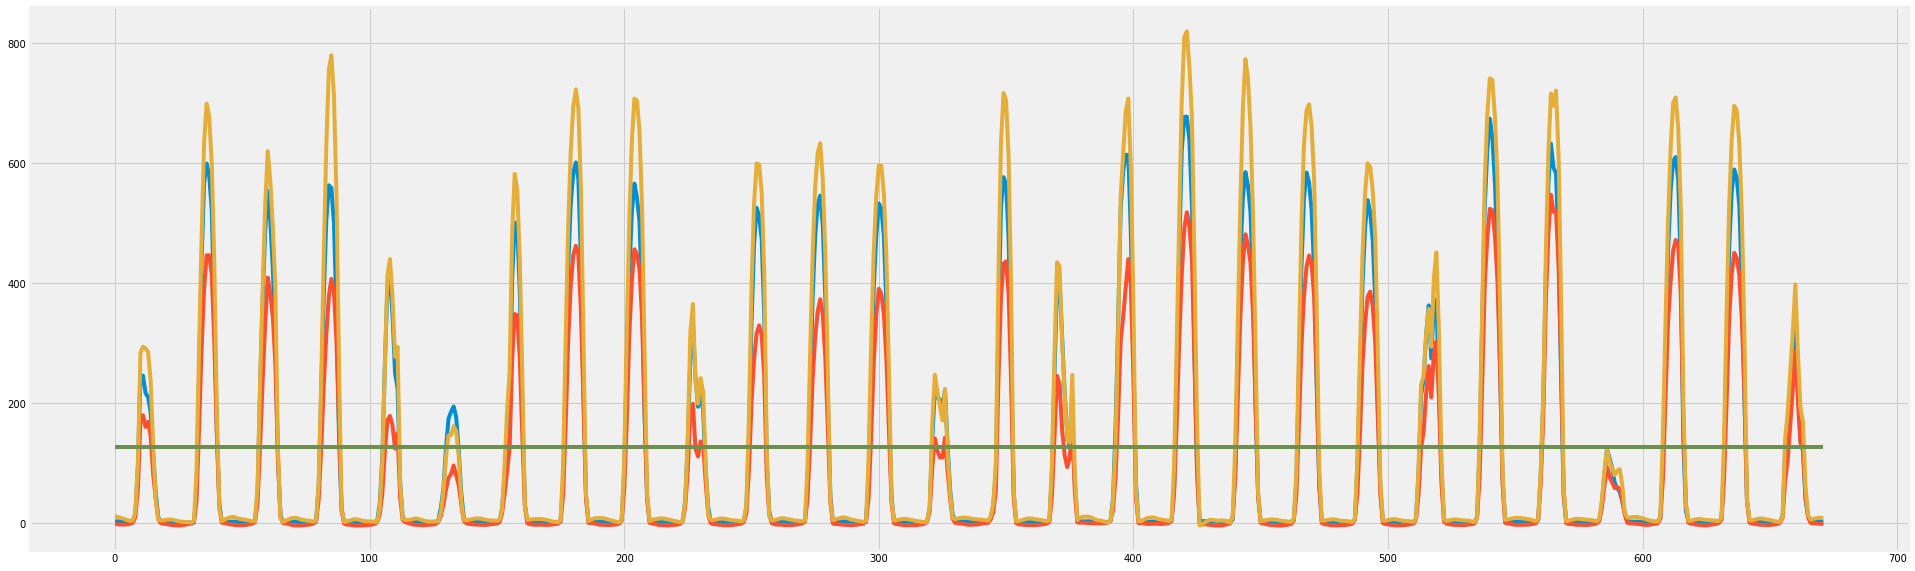

In [ ]:
# validation visualization
plt.figure(figsize = (30, 10))
plt.plot(sample_submission['dangjin_floating'][:672])
plt.plot(sample_submission['dangjin_warehouse'][:672])
plt.plot(sample_submission['dangjin'][:672])
plt.plot(sample_submission['ulsan'][:672])